In [88]:
import os
import fastf1
import matplotlib.pyplot as plt
from fastf1 import get_event_schedule
import openpyxl
import pandas as pd
import numpy as np
import shutil

In [89]:
# Crea la carpeta 'cache' si no existe
os.makedirs('cache', exist_ok=True)

# Activa la caché
fastf1.Cache.enable_cache('cache')

# CALENDARIO

### DATA CLEANING

In [90]:
# Obtenemos calendario 2025

calendario_25 = get_event_schedule(2025)

# AJUSTAMOS COLUMNAS

# INDICAMOS CUANDO ES Pre-Season

calendario_25.loc[calendario_25['Session5']!="Race",'Session5'] = "Pre-Season"
calendario_25.loc[calendario_25['Session4']!="Qualifying",'Session4'] = "Pre-Season"
calendario_25.iloc[0,calendario_25.columns.get_loc('Session3')]= 'Pre-Season'
calendario_25.iloc[0,calendario_25.columns.get_loc('Session2')]='Pre-Season'
calendario_25.iloc[0,calendario_25.columns.get_loc('Session1')]='Pre-Season'

#CREAMOS HORA LOCAL DE TODAS LAS SESIONES 

#-- Función para ajustar la hora local --#
def ajustar_hora_local(session_date_utc):
    if pd.isna(session_date_utc):
        return None
    local_time = session_date_utc + pd.to_timedelta(1, unit='h')
    return local_time.strftime('%H:%M:%S')

# Aplicamos la función a todas las sesiones
for i in range(1, 6):
    calendario_25[f'Local_Time_Session{i}'] = calendario_25[f'Session{i}DateUtc'].apply(ajustar_hora_local)
    calendario_25[f'Date_Session_{i}'] = calendario_25[f'Session{i}DateUtc'].dt.date

#Eliminamos columnas que no necesitamos

calendario_25.drop(columns=["F1ApiSupport","Session1Date","Session1DateUtc","Session2Date","Session2DateUtc","Session3Date","Session3DateUtc","Session4Date",
                         "Session4DateUtc","Session5Date","Session5DateUtc"],inplace=True)
# Ordenamos las columnas

columnas_ordenadas = [
    'RoundNumber', 'Country', 'Location','OfficialEventName','EventFormat',
    'Session1', 'Date_Session_1', 'Local_Time_Session1',
    'Session2', 'Date_Session_2', 'Local_Time_Session2',
    'Session3', 'Date_Session_3', 'Local_Time_Session3',
    'Session4', 'Date_Session_4', 'Local_Time_Session4',
    'Session5', 'Date_Session_5', 'Local_Time_Session5'
]

calendario_25 = calendario_25.loc[:, columnas_ordenadas]

# Ajustamos nombre de las carreras

calendario_25['OfficialEventName'] = calendario_25['OfficialEventName'].str.replace('^FORMULA 1 ','',regex=True)

# Guardamos en formato CSV

calendario_25.to_csv(r'C:\Users\ejgar\OneDrive\Documentos\GitHub\F1_Analysis\Data\Calendario_25.csv',index=False)



In [91]:
calendario_25.head()

,RoundNumber,Country,Location,OfficialEventName,EventFormat,Session1,Date_Session_1,Local_Time_Session1,Session2,Date_Session_2,Local_Time_Session2,Session3,Date_Session_3,Local_Time_Session3,Session4,Date_Session_4,Local_Time_Session4,Session5,Date_Session_5,Local_Time_Session5
0,0,Bahrain,Sakhir,ARAMCO PRE-SEASON TESTING 2025,testing,Pre-Season,2025-02-26,08:00:00,Pre-Season,2025-02-27,08:00:00,Pre-Season,2025-02-28,08:00:00,Pre-Season,NaT,None,Pre-Season,NaT,None
1,1,Australia,Melbourne,LOUIS VUITTON AUSTRALIAN GRAND PRIX 2025,conventional,Practice 1,2025-03-14,02:30:00,Practice 2,2025-03-14,06:00:00,Practice 3,2025-03-15,02:30:00,Qualifying,2025-03-15,06:00:00,Race,2025-03-16,05:00:00
2,2,China,Shanghai,HEINEKEN CHINESE GRAND PRIX 2025,sprint_qualifying,Practice 1,2025-03-21,04:30:00,Sprint Qualifying,2025-03-21,08:30:00,Sprint,2025-03-22,04:00:00,Qualifying,2025-03-22,08:00:00,Race,2025-03-23,08:00:00
3,3,Japan,Suzuka,LENOVO JAPANESE GRAND PRIX 2025,conventional,Practice 1,2025-04-04,03:30:00,Practice 2,2025-04-04,07:00:00,Practice 3,2025-04-05,03:30:00,Qualifying,2025-04-05,07:00:00,Race,2025-04-06,06:00:00
4,4,Bahrain,Sakhir,GULF AIR BAHRAIN GRAND PRIX 2025,conventional,Practice 1,2025-04-11,12:30:00,Practice 2,2025-04-11,16:00:00,Practice 3,2025-04-12,13:30:00,Qualifying,2025-04-12,17:00:00,Race,2025-04-13,16:00:00


In [92]:
# Visualizamos como se queda la tabla calendario
calendario_25.info()

<class 'fastf1.events.EventSchedule'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   RoundNumber          25 non-null     int64 
 1   Country              25 non-null     object
 2   Location             25 non-null     object
 3   OfficialEventName    25 non-null     object
 4   EventFormat          25 non-null     object
 5   Session1             25 non-null     object
 6   Date_Session_1       25 non-null     object
 7   Local_Time_Session1  25 non-null     object
 8   Session2             25 non-null     object
 9   Date_Session_2       25 non-null     object
 10  Local_Time_Session2  25 non-null     object
 11  Session3             25 non-null     object
 12  Date_Session_3       25 non-null     object
 13  Local_Time_Session3  25 non-null     object
 14  Session4             25 non-null     object
 15  Date_Session_4       24 non-null     object
 16  Local_Time

## Analizamos los datos de la última carrera

### CLASIFICACIÓN

In [93]:
last_race = calendario_25.iloc[1] 

clasificacion_session = fastf1.get_session(2025, last_race['RoundNumber'], "Q")
clasificacion_session.load()

# La tabla de resultados con tiempos de Q1, Q2, Q3 y posición se encuentra en:
clasificacion_results = clasificacion_session.results

# Función para extraer el formato mm:ss.SSS
def extraer_minutos_segundos(tiempo):
    if pd.isna(tiempo):
        return None
    tiempo_str = str(tiempo)
    if 'days' in tiempo_str:
        tiempo_str = tiempo_str.split(' ')[-1]  # Extraer hh:mm:ss.SSS
    minutos_segundos = tiempo_str.split(':')[-2:]  # Extraer mm:ss.SSS
    return ':'.join(minutos_segundos)

# Aplicar la función a las columnas Q1, Q2 y Q3
clasificacion_results['Q1'] = clasificacion_results['Q1'].apply(extraer_minutos_segundos)
clasificacion_results['Q2'] = clasificacion_results['Q2'].apply(extraer_minutos_segundos)
clasificacion_results['Q3'] = clasificacion_results['Q3'].apply(extraer_minutos_segundos)

# Elegimos las columnas que nos queremos quedar
df_Qualy = clasificacion_results[['DriverNumber','DriverId','Abbreviation','TeamName','Q1', 'Q2', 'Q3', 'Position','TeamColor','HeadshotUrl']]
df_Qualy['RoundNumber'] = 1
df_Qualy['RoundName'] = 'Australian Grand Prix'

core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.5.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '1', '63', '22', '23', '16', '44', '10', '55', '6', '14', '18', '7', '5', '12', '27', '30', '31', '87']
C:\Users\ejgar\AppData\Local\Temp\ipykernel_13996\2391192810.py:26: SettingWithCopyWarning: 
A value is try

In [94]:
df_Qualy.head()

,DriverNumber,DriverId,Abbreviation,TeamName,Q1,Q2,Q3,Position,TeamColor,HeadshotUrl,RoundNumber,RoundName
4,4,norris,NOR,McLaren,01:15.912000,01:15.415000,01:15.096000,1.0,FF8000,https://media.formula1.com/d_driver_fallback_i...,1,Australian Grand Prix
81,81,piastri,PIA,McLaren,01:16.062000,01:15.468000,01:15.180000,2.0,FF8000,https://media.formula1.com/d_driver_fallback_i...,1,Australian Grand Prix
1,1,max_verstappen,VER,Red Bull Racing,01:16.018000,01:15.565000,01:15.481000,3.0,3671C6,https://media.formula1.com/d_driver_fallback_i...,1,Australian Grand Prix
63,63,russell,RUS,Mercedes,01:15.971000,01:15.798000,01:15.546000,4.0,27F4D2,https://media.formula1.com/d_driver_fallback_i...,1,Australian Grand Prix
22,22,tsunoda,TSU,Racing Bulls,01:16.225000,01:16.009000,01:15.670000,5.0,6692FF,https://media.formula1.com/d_driver_fallback_i...,1,Australian Grand Prix


In [95]:
df_Qualy.info()

<class 'fastf1.core.SessionResults'>
Index: 20 entries, 4 to 87
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DriverNumber  20 non-null     object 
 1   DriverId      20 non-null     object 
 2   Abbreviation  20 non-null     object 
 3   TeamName      20 non-null     object 
 4   Q1            19 non-null     object 
 5   Q2            15 non-null     object 
 6   Q3            10 non-null     object 
 7   Position      20 non-null     float64
 8   TeamColor     20 non-null     object 
 9   HeadshotUrl   20 non-null     object 
 10  RoundNumber   20 non-null     int64  
 11  RoundName     20 non-null     object 
dtypes: float64(1), int64(1), object(10)
memory usage: 2.0+ KB


## DATOS DE CARRERA

In [96]:
# Creamos una nueva caché para los datos de la carrera
os.makedirs('cache_new', exist_ok=True)
fastf1.Cache.enable_cache('cache_new')

# Ahora intenta obtener la sesión de carrera otra vez
race_session = fastf1.get_session(2025, last_race['RoundNumber'], "R")
race_session.load()
df_race = race_session.results

df_race = df_race[['Abbreviation','TeamName','ClassifiedPosition','GridPosition','Time','Status','Points','TeamColor','HeadshotUrl']]

# Renombramos columnas
df_race = df_race.rename(columns={
    'Abbreviation':'Name',
    'ClassifiedPosition':'FinalPosition',
    'GridPosition':'QualifyingPosition',
})

#Cambiamos tipo de datos a columnas
df_race['Points'] = df_race['Points'].astype(int)
df_race['QualifyingPosition'] = df_race['QualifyingPosition'].astype(int)

# Función para extraer el formato mm:ss.SSS
def extraer_minutos_segundos(tiempo):
    if pd.isna(tiempo):
        return None
    tiempo_str = str(tiempo)
    if 'days' in tiempo_str:
        tiempo_str = tiempo_str.split(' ')[-1]  # Extraer hh:mm:ss.SSS
    # minutos_segundos = tiempo_str.split(':')[-2:]  # Extraer mm:ss.SSS
    # return ':'.join(minutos_segundos)
    return tiempo_str


#Creamos columna TotalTime
tiempo_ganador = df_race['Time'][0]
TotalTime = []
for tiempo in df_race['Time']:
    if tiempo == tiempo_ganador:
        TotalTime.append(tiempo)
    else:
        TotalTime.append(tiempo_ganador + tiempo)
df_race['TotalTime'] = TotalTime

# Aplicar la función a las columnas Time y TotalTime
df_race['Time'] = df_race['Time'].apply(extraer_minutos_segundos)
df_race['TotalTime'] = df_race['TotalTime'].apply(extraer_minutos_segundos)


core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']
C:\Users\ejgar\AppData\Local\Temp\ipykernel_13996\237840825.

In [99]:
df_race.head()


,Name,TeamName,FinalPosition,QualifyingPosition,Time,Status,Points,TeamColor,HeadshotUrl,TotalTime
4,NOR,McLaren,1,1,01:42:06.304000,Finished,25,FF8000,https://media.formula1.com/d_driver_fallback_i...,01:42:06.304000
1,VER,Red Bull Racing,2,3,00:00:00.895000,Finished,18,3671C6,https://media.formula1.com/d_driver_fallback_i...,01:42:07.199000
63,RUS,Mercedes,3,4,00:00:08.481000,Finished,15,27F4D2,https://media.formula1.com/d_driver_fallback_i...,01:42:14.785000
12,ANT,Mercedes,4,16,00:00:10.135000,Finished,12,27F4D2,https://media.formula1.com/d_driver_fallback_i...,01:42:16.439000
23,ALB,Williams,5,6,00:00:12.773000,Finished,10,64C4FF,https://media.formula1.com/d_driver_fallback_i...,01:42:19.077000


In [100]:
df_race.info()

<class 'fastf1.core.SessionResults'>
Index: 20 entries, 4 to 6
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Name                20 non-null     object
 1   TeamName            20 non-null     object
 2   FinalPosition       20 non-null     object
 3   QualifyingPosition  20 non-null     int64 
 4   Time                14 non-null     object
 5   Status              20 non-null     object
 6   Points              20 non-null     int64 
 7   TeamColor           20 non-null     object
 8   HeadshotUrl         20 non-null     object
 9   TotalTime           14 non-null     object
dtypes: int64(2), object(8)
memory usage: 1.7+ KB


## Hacemos lo mismo para el calendario 2024

In [13]:
# Obtenemos calendario_24 2025

calendario_24 = get_event_schedule(2024)

# AJUSTAMOS COLUMNAS

# INDICAMOS CUANDO ES Pre-Season

calendario_24.loc[calendario_24['Session5']!="Race",'Session5'] = "Pre-Season"
calendario_24.loc[calendario_24['Session4']!="Qualifying",'Session4'] = "Pre-Season"
calendario_24.iloc[0,calendario_24.columns.get_loc('Session3')]= 'Pre-Season'
calendario_24.iloc[0,calendario_24.columns.get_loc('Session2')]='Pre-Season'
calendario_24.iloc[0,calendario_24.columns.get_loc('Session1')]='Pre-Season'

#CREAMOS HORA LOCAL DE TODAS LAS SESIONES 

#-- Función para ajustar la hora local --#
def ajustar_hora_local(session_date_utc):
    if pd.isna(session_date_utc):
        return None
    local_time = session_date_utc + pd.to_timedelta(1, unit='h')
    return local_time.strftime('%H:%M:%S')

# Aplicamos la función a todas las sesiones
for i in range(1, 6):
    calendario_24[f'Local_Time_Session{i}'] = calendario_24[f'Session{i}DateUtc'].apply(ajustar_hora_local)
    calendario_24[f'Date_Session_{i}'] = calendario_24[f'Session{i}DateUtc'].dt.date

#Eliminamos columnas que no necesitamos

calendario_24.drop(columns=["F1ApiSupport","Session1Date","Session1DateUtc","Session2Date","Session2DateUtc","Session3Date","Session3DateUtc","Session4Date",
                         "Session4DateUtc","Session5Date","Session5DateUtc"],inplace=True)
# Ordenamos las columnas

columnas_ordenadas = [
    'RoundNumber', 'Country', 'Location','OfficialEventName','EventFormat',
    'Session1', 'Date_Session_1', 'Local_Time_Session1',
    'Session2', 'Date_Session_2', 'Local_Time_Session2',
    'Session3', 'Date_Session_3', 'Local_Time_Session3',
    'Session4', 'Date_Session_4', 'Local_Time_Session4',
    'Session5', 'Date_Session_5', 'Local_Time_Session5'
]

calendario_24 = calendario_24.loc[:, columnas_ordenadas]

# Ajustamos nombre de las carreras

calendario_24['OfficialEventName'] = calendario_24['OfficialEventName'].str.replace('^FORMULA 1 ','',regex=True)

# Guardamos en formato CSV

calendario_24.to_csv(r'C:\Users\ejgar\OneDrive\Documentos\GitHub\F1_Analysis\Data\Calendario_24.csv',index=False)

In [14]:
calendario_24.head()

,RoundNumber,Country,Location,OfficialEventName,EventFormat,Session1,Date_Session_1,Local_Time_Session1,Session2,Date_Session_2,Local_Time_Session2,Session3,Date_Session_3,Local_Time_Session3,Session4,Date_Session_4,Local_Time_Session4,Session5,Date_Session_5,Local_Time_Session5
0,0,Bahrain,Sakhir,ARAMCO PRE-SEASON TESTING 2024,testing,Pre-Season,2024-02-21,08:00:00,Pre-Season,2024-02-22,08:00:00,Pre-Season,2024-02-23,08:00:00,Pre-Season,NaT,None,Pre-Season,NaT,None
1,1,Bahrain,Sakhir,GULF AIR BAHRAIN GRAND PRIX 2024,conventional,Practice 1,2024-02-29,12:30:00,Practice 2,2024-02-29,16:00:00,Practice 3,2024-03-01,13:30:00,Qualifying,2024-03-01,17:00:00,Race,2024-03-02,16:00:00
2,2,Saudi Arabia,Jeddah,STC SAUDI ARABIAN GRAND PRIX 2024,conventional,Practice 1,2024-03-07,14:30:00,Practice 2,2024-03-07,18:10:00,Practice 3,2024-03-08,14:30:00,Qualifying,2024-03-08,18:00:00,Race,2024-03-09,18:00:00
3,3,Australia,Melbourne,ROLEX AUSTRALIAN GRAND PRIX 2024,conventional,Practice 1,2024-03-22,02:30:00,Practice 2,2024-03-22,06:00:00,Practice 3,2024-03-23,02:30:00,Qualifying,2024-03-23,06:00:00,Race,2024-03-24,05:00:00
4,4,Japan,Suzuka,MSC CRUISES JAPANESE GRAND PRIX 2024,conventional,Practice 1,2024-04-05,03:30:00,Practice 2,2024-04-05,07:00:00,Practice 3,2024-04-06,03:30:00,Qualifying,2024-04-06,07:00:00,Race,2024-04-07,06:00:00


In [15]:
calendario_24.info()

<class 'fastf1.events.EventSchedule'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   RoundNumber          25 non-null     int64 
 1   Country              25 non-null     object
 2   Location             25 non-null     object
 3   OfficialEventName    25 non-null     object
 4   EventFormat          25 non-null     object
 5   Session1             25 non-null     object
 6   Date_Session_1       25 non-null     object
 7   Local_Time_Session1  25 non-null     object
 8   Session2             25 non-null     object
 9   Date_Session_2       25 non-null     object
 10  Local_Time_Session2  25 non-null     object
 11  Session3             25 non-null     object
 12  Date_Session_3       25 non-null     object
 13  Local_Time_Session3  25 non-null     object
 14  Session4             25 non-null     object
 15  Date_Session_4       24 non-null     object
 16  Local_Time

# SIGUIENTE PARTE DEL ANALISIS

In [9]:
race = fastf1.get_event(2023,5)

In [3]:
sesion = fastf1.get_session(2023,5,'R')
sesion.load()

core           INFO 	Loading data for Miami Grand Prix - Race [v3.5.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cach

In [26]:
laps_ALO = sesion.laps.pick_driver('ALO')
laps_ALO = laps_ALO[['LapNumber','LapTime']]
laps_ALO['Driver'] = "ALO"

laps_VER = sesion.laps.pick_driver('VER')
laps_VER = laps_ALO[['LapNumber','LapTime']]
laps_VER['Driver'] = "VER"

c:\Users\ejgar\AppData\Local\Programs\Python\Python313\Lib\site-packages\fastf1\core.py:3035: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
c:\Users\ejgar\AppData\Local\Programs\Python\Python313\Lib\site-packages\fastf1\core.py:3035: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


In [29]:
laps = pd.concat([laps_ALO,laps_VER],axis = 0 , ignore_index = True)

In [30]:
laps

,LapNumber,LapTime,Driver
0,1.0,0 days 00:01:37.248000,ALO
1,2.0,0 days 00:01:34.175000,ALO
2,3.0,0 days 00:01:33.258000,ALO
3,4.0,0 days 00:01:33.472000,ALO
4,5.0,0 days 00:01:33.756000,ALO
...,...,...,...
109,53.0,0 days 00:01:31.735000,VER
110,54.0,0 days 00:01:31.454000,VER
111,55.0,0 days 00:01:31.760000,VER
112,56.0,0 days 00:01:31.595000,VER


In [32]:
laps.to_csv(r'C:\Users\ejgar\OneDrive\Escritorio\Programación\Datos F1\alonso_vueltas_carrera_5.csv', index=False)

In [24]:
fastest_lap = sesion.laps.pick_fastest()
print(f"Vuelta más rápida: {fastest_lap['LapTime']}")

Vuelta más rápida: 0 days 00:01:29.708000


In [ ]:
# Carga los datos de una carrera (por año y ronda)
race = fastf1.get_event(2023, 5)  # 5ta carrera de 2023
print(race['EventName'], race['Location'])

In [11]:
session = fastf1.get_session(2023, 5, 'Q')  # Clasificación
session.load()

# Selecciona dos pilotos para comparar
leclerc = session.laps.pick_driver('LEC').pick_fastest()
verstappen = session.laps.pick_driver('VER').pick_fastest()

print(f"Leclerc: {leclerc['LapTime']}, Verstappen: {verstappen['LapTime']}")

core           INFO 	Loading data for Miami Grand Prix - Qualifying [v3.5.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	D

Leclerc: 0 days 00:01:26.964000, Verstappen: 0 days 00:01:26.814000


c:\Users\ejgar\AppData\Local\Programs\Python\Python313\Lib\site-packages\fastf1\core.py:3035: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
c:\Users\ejgar\AppData\Local\Programs\Python\Python313\Lib\site-packages\fastf1\core.py:3035: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


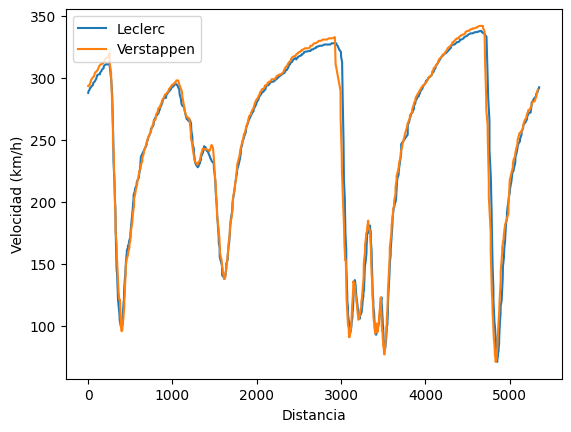

In [13]:
tel = leclerc.get_telemetry()
plt.plot(tel['Distance'], tel['Speed'], label='Leclerc')
plt.plot(verstappen.get_telemetry()['Distance'], verstappen.get_telemetry()['Speed'], label='Verstappen')
plt.xlabel('Distancia')
plt.ylabel('Velocidad (km/h)')
plt.legend()
plt.show()